In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random
import bilby

In [2]:
# different ln(likelihood) functions

def lnlikePE(var1, var2, N, C12, Sh):
    lnlike1 = -0.5*np.log(2*np.pi*var1*var2/N)
    lnlike2 = -0.5*(Sh-C12)**2/(var1*var2/N)
    return lnlike1 + lnlike2

def lnlikeSS(var1, var2, N, C12, Sh):
    lnlike1 = -0.5*N*(2*np.log(2*np.pi) + np.log(var1*var2) + 2.)
    lnlike2 = -0.5*N*(Sh**2 - 2*Sh*C12)/(var1*var2)
    return lnlike1 + lnlike2

def lnlikeSSPE(var1, var2, N, C12, Sh):
    lnlike1 = 0.5*np.log(2*np.pi*var1*var2/N) - 0.5*N*(2*np.log(2*np.pi) 
                                                       + np.log(var1*var2) + 2. - C12**2/(var1*var2))
    lnlike2 = lnlikePE(var1, var2, N, C12, Sh)
    return lnlike1 + lnlike2

In [3]:
# test case
var1 = 1.2
var2 = 1.5
N = 1024
C12 = 1.75
Sh = 0.8

PE = lnlikePE(var1, var2, N, C12, Sh)
SS1 = lnlikeSS(var1, var2, N, C12, Sh)
SS2 = lnlikeSSPE(var1, var2, N, C12, Sh)

print(PE, SS1, SS2)

-254.45820707396712 -2592.5328884330543 -2592.5328884330543


# Sufficient statistic test, white noise

In [4]:
# set some parameter values

# number of samples
N = 128

# injected values of noise and signal variances
Sh_true  = 0.3
Sn1_true = 1   
Sn2_true = 1 

# expected snr
rho = Sh_true * np.sqrt(N) / np.sqrt(Sn1_true * Sn2_true)
print('expected snr =', rho)

# flat priors for all parameters for standard gaussian model (Sh, Sn1, Sn2)
pmin = np.array([1e-6, 0.5, 0.5])
pmax = np.array([1.0, 1.5, 1.5])

# discrete values for parameters for standard gaussian model
N_grid = 50
Sh  = np.linspace(pmin[0], pmax[0], N_grid)
Sn1 = np.linspace(pmin[1], pmax[1], N_grid)
Sn2 = np.linspace(pmin[2], pmax[2], N_grid)

deltaSh  = Sh[1]-Sh[0]
deltaSn1 = Sn1[1]-Sn1[0]
deltaSn2 = Sn2[1]-Sn2[0]

expected snr = 3.394112549695428


0.2102424465326729 0.8955979065650987 1.119504276220617


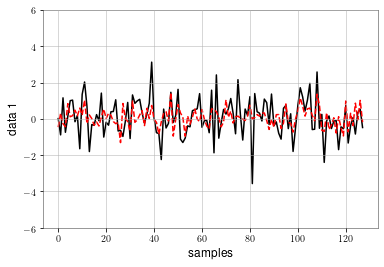

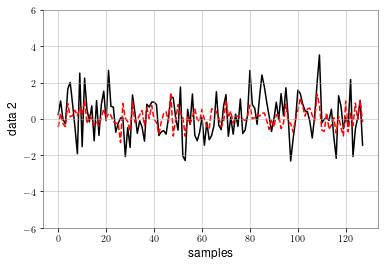

In [5]:
# simulate data
random.seed(1234)

# generate random samples
n1 = random.normal(0, np.sqrt(Sn1_true), N)
n2 = random.normal(0, np.sqrt(Sn2_true), N)
h  = random.normal(0, np.sqrt(Sh_true), N)

# add signal + noise
d1 = n1 + h
d2 = n2 + h

# estimators
C11 = np.sum(d1**2)
C22 = np.sum(d2**2)
C12 = np.sum(d1*d2)

Sh_hat  = C12/N
Sn1_hat = C11/N - Sh_hat
Sn2_hat = C22/N - Sh_hat

print(Sh_hat, Sn1_hat, Sn2_hat)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(d1, color='k')
plt.plot(h, linestyle='dashed', color='r')
plt.xlabel('samples')
plt.ylabel('data 1')
plt.ylim((-6,6))
plt.savefig('./suffstat-data1.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(d2, color='k')
plt.plot(h, linestyle='dashed', color='r')
plt.xlabel('samples')
plt.ylabel('data 2')
plt.ylim((-6,6))
plt.savefig('./suffstat-data2.pdf', bbox_inches='tight', dpi=400)

In [6]:
# calculate marg posterior for Sh using sufficient statistic expression for likelihood
post_Sh = np.zeros(N_grid)

for ii in range(0,N_grid):
    #print ii
    
    for jj in range(0,N_grid):

        for kk in range(0,N_grid):
            
            beta = Sn1[jj]*Sn2[kk] + (Sn1[jj] + Sn2[kk])*Sh[ii]
            g = Sh_hat*(Sn1[jj]+Sn2[kk]) + Sn1_hat*(Sn2[kk]+Sh[ii]) + Sn2_hat*(Sn1[jj]+Sh[ii])
            
            #iN = np.diag(np.ones(N))
            
            #Cn = np.bmat([[Sn1[jj]*iN, 0.*iN],[0.*iN, Sn2[kk]*iN]])
            #C  = Cn + Sh[ii]*np.bmat([[iN, iN], [iN, iN]])
                      
            #fac1 = -0.5 * np.log(np.linalg.det(2.0*np.pi*C))
            lnlike1 = -0.5 * N * (2.0*np.log(2.0*np.pi) + np.log(beta))
            lnlike2 = -0.5 * (N/beta) * g
            
            lnlike = lnlike1 + lnlike2
            like = np.exp(lnlike)
            
            post_Sh[ii] = post_Sh[ii] + like

            

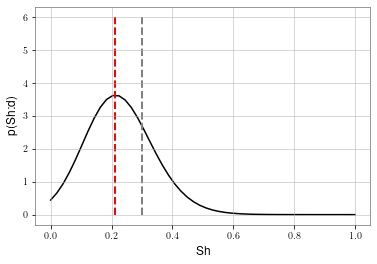

In [7]:
# plot posterior for Sh

# first normalize
post_Sh = post_Sh/np.sum(post_Sh*deltaSh)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sh, post_Sh, color='k')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sh')
plt.ylabel('p(Sh:d)')
plt.savefig('./suffstat-postSh.pdf', bbox_inches='tight', dpi=400)

In [8]:
# calculate marg posterior for Sn1 using sufficient statistic expression for likelihood
post_Sn1 = np.zeros(N_grid)

for ii in range(0,N_grid):
        
    for jj in range(0,N_grid):

        for kk in range(0,N_grid):
            
            beta = Sn1[ii]*Sn2[jj] + (Sn1[ii] + Sn2[jj])*Sh[kk]
            g = Sh_hat*(Sn1[ii]+Sn2[jj]) + Sn1_hat*(Sn2[jj]+Sh[kk]) + Sn2_hat*(Sn1[ii]+Sh[kk])
            
            lnlike1 = -0.5 * N * (2.0*np.log(2.0*np.pi) + np.log(beta))
            lnlike2 = -0.5 * (N/beta) * g
                        
            lnlike = lnlike1 + lnlike2
            like = np.exp(lnlike)
            
            post_Sn1[ii] = post_Sn1[ii] + like

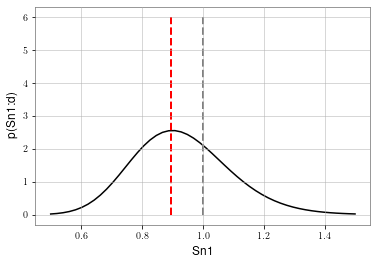

In [9]:
# plot posterior for Sn1

# first normalize
post_Sn1 = post_Sn1/np.sum(post_Sn1*deltaSh)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sn1, post_Sn1, color='k')
plt.plot((Sn1_true, Sn1_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn1_hat, Sn1_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sn1')
plt.ylabel('p(Sn1:d)')
plt.savefig('./suffstat-postSn1.pdf', bbox_inches='tight', dpi=400)

In [10]:
# calculate marg posterior for Sn2 using sufficient statistic expression for likelihood
post_Sn2 = np.zeros(N_grid)

for ii in range(0,N_grid):
        
    for jj in range(0,N_grid):

        for kk in range(0,N_grid):
            
            beta = Sn1[jj]*Sn2[ii] + (Sn1[jj] + Sn2[ii])*Sh[kk]
            g = Sh_hat*(Sn1[jj]+Sn2[ii]) + Sn1_hat*(Sn2[ii]+Sh[kk]) + Sn2_hat*(Sn1[jj]+Sh[kk])
            
            lnlike1 = -0.5 * N * (2.0*np.log(2.0*np.pi) + np.log(beta))
            lnlike2 = -0.5 * (N/beta) * g
                        
            lnlike = lnlike1 + lnlike2
            like = np.exp(lnlike)
            
            post_Sn2[ii] = post_Sn2[ii] + like

            



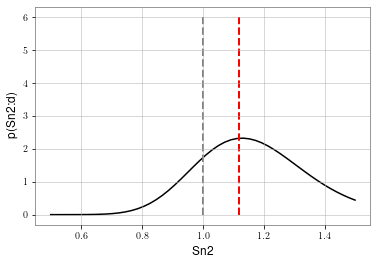

In [11]:
# plot posterior for Sn2

# first normalize
post_Sn2 = post_Sn2/np.sum(post_Sn2*deltaSh)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sn2, post_Sn2, color='k')
plt.plot((Sn2_true, Sn2_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn2_hat, Sn2_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sn2')
plt.ylabel('p(Sn2:d)')
plt.savefig('./suffstat-postSn2.pdf', bbox_inches='tight', dpi=400)

17:32 bilby INFO    : Running for label 'suffStatTest', output will be saved to 'outdir'
17:32 bilby INFO    : Search parameters:
17:32 bilby INFO    :   Sh = Uniform(minimum=0, maximum=1.0, name='Sh', latex_label='Sh', unit=None, boundary=None)
17:32 bilby INFO    :   Sn1 = Uniform(minimum=0.5, maximum=1.5, name='Sn1', latex_label='Sn1', unit=None, boundary=None)
17:32 bilby INFO    :   Sn2 = Uniform(minimum=0.5, maximum=1.5, name='Sn2', latex_label='Sn2', unit=None, boundary=None)
17:32 bilby INFO    : Single likelihood evaluation took 7.615e-04 s


0it [00:00, ?it/s]

17:32 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c185d62b0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
17:32 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:32 bilby INFO    : Using dynesty version 1.0.1
17:32 bilby INFO    : Using the bilby-implemented rwalk sample 

2830it [00:54, 52.29it/s, bound:163 nc:1 ncall:70573 eff:4.7% logz=-389.29+/-0.09 dlogz:0.000>0.10] 



17:33 bilby INFO    : Sampling time: 0:00:00
17:33 bilby INFO    : Summary of results:
nsamples: 3330
ln_noise_evidence:    nan
ln_evidence: -389.289 +/-  0.091
ln_bayes_factor:    nan +/-  0.091



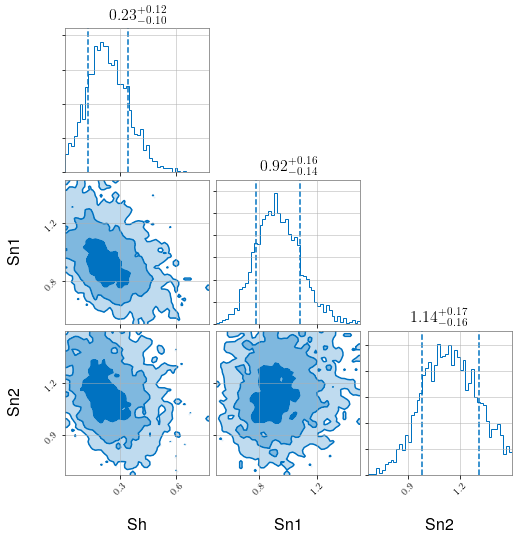

In [12]:
# A few simple setup steps
label = 'suffStatTest'
outdir = 'outdir'
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

class GaussianLikelihood(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Sh': None, 'Sn1': None, 'Sn2': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        C11 = np.sum(d1**2)
        C22 = np.sum(d2**2)
        C12 = np.sum(d1*d2)
        
        self.Sh_hat = C12/N
        self.Sn1_hat = C11/N - self.Sh_hat
        self.Sn2_hat = C22/N - self.Sh_hat
        
    def log_likelihood(self):
        Sh = self.parameters['Sh']
        Sn1 = self.parameters['Sn1']
        Sn2 = self.parameters['Sn2']
        
        ###########################################
        # 1. the following calculation uses the sufficient statistic form of the likelihood
        # (using this form for bayesian inference is then just a trivial test of MCMC)
        
        #N = np.size(self.d1)
        #beta = Sn1*Sn2 + (Sn1 + Sn2)*Sh        
        #g = self.Sh_hat*(Sn1+Sn2) + self.Sn1_hat*(Sn2+Sh) + self.Sn2_hat*(Sn1+Sh)
        
        #lnlike1 = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        #lnlike2 = -0.5 * (N/beta) * g
        #lnlike = lnlike1 + lnlike2      
        
        ############################################        
        # 2. the following calculation is does not use sufficient statistics nor the 
        # assumption that the noise and signal are white.
        # as such, it is computationally intensive but valid method of comparing against
        # the posteriors calculated from the sufficient statistic form of the likelihood
                
        # extract length of data
        #N = np.size(self.d1)
        
        # construct NxN identity matrix
        #iN = np.diag(np.ones(N))

        # make d1, d2 into a column vector
        #d = np.bmat([self.d1, self.d2])
        #d = np.transpose(d) 
        
        # construct noise and data covariance matrices
        #Cn = np.bmat([[Sn1*iN, 0.*iN],[0.*iN, Sn2*iN]])
        #C  = Cn + Sh*np.bmat([[iN, iN], [iN, iN]])
        
        # invert the covariance matrices
        #invC  = np.linalg.inv(C)
        
        # calculate normalization factors
        #norm = 1.0/np.sqrt(np.linalg.det(2.0*np.pi*C))
                
        # calculate likelihood function and ln likelihood
        #like = norm * np.exp(-0.5 * np.dot(np.transpose(d), np.dot(invC, d)))
        #lnlike = np.log(like)
        
        ############################################        
        # 3. the following calculation does not use sufficient statistics, but it does
        # assume that the data are white.  
        # (this is the best model for comparing against the posteriors calculated from 
        # sufficient statistics)
                        
        # extract length of data
        N = self.N
        d1 = self.d1
        d2 = self.d2
        
        # construct NxN identity matrix
        iN = np.diag(np.ones(N))
        
        # make d1, d2 into a column vector
        d = np.bmat([d1, d2])
        d = np.transpose(d) 
        
        # construct noise and data covariance matrices
        Cn = np.bmat([[Sn1*iN, 0.*iN],[0.*iN, Sn2*iN]])
        C  = Cn + Sh*np.bmat([[iN, iN], [iN, iN]])
        
        # invert the covariance matrices using whiteness of data
        beta = Sn1*Sn2 + (Sn1 + Sn2)*Sh  
        invC  = (1.0/beta) * np.bmat([[(Sn2+Sh)*iN, -Sh*iN],[-Sh*iN, (Sn1+Sh)*iN]])
        
        # calculate ln of likelihood function 
        lnlike1 = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        lnlike2 = -0.5 * np.dot(np.transpose(d), np.dot(invC, d))[0]
        lnlike = lnlike1+lnlike2
        lnlike = float(lnlike)
        
        return lnlike

likelihood = GaussianLikelihood(d1, d2)
priors = dict(Sh=bilby.core.prior.Uniform(0, 1., 'Sh'),
              Sn1=bilby.core.prior.Uniform(0.5, 1.5, 'Sn1'),
              Sn2=bilby.core.prior.Uniform(0.5, 1.5, 'Sn2'))

# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=500,
    walks=10, outdir=outdir, label=label)
result.plot_corner()


# compare posteriors for the two methods

/anaconda3/envs/pta/lib/python3.7/site-packages/gwpy/plot/axes.py:319: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  return super().hist(x, *args, **kwargs)


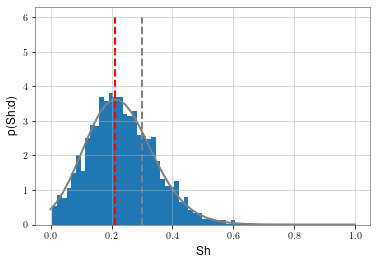

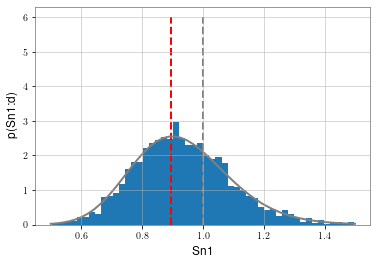

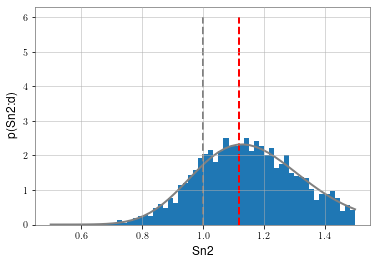

In [14]:
# Sh
chain_Sh = result.posterior["Sh"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sh, bins=50, normed='true')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sh, post_Sh, color='grey', linewidth=2, linestyle='solid')
plt.xlabel('Sh')
plt.ylabel('p(Sh:d)')
plt.savefig('./suffstat-postSh-compare.pdf', bbox_inches='tight', dpi=400)

# Sn1
chain_Sn1 = result.posterior["Sn1"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sn1, bins=50, normed='true')
plt.plot((Sn1_true, Sn1_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn1_hat, Sn1_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sn1, post_Sn1, color='grey', linewidth=2, linestyle='solid')
plt.xlabel('Sn1')
plt.ylabel('p(Sn1:d)')
plt.savefig('./suffstat-postSn1-compare.pdf', bbox_inches='tight', dpi=400)

# Sn2
chain_Sn2 = result.posterior["Sn2"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sn2, bins=50, normed='true')
plt.plot((Sn2_true, Sn2_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn2_hat, Sn2_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sn2, post_Sn2, color='grey', linewidth=2, linestyle='solid')
plt.xlabel('Sn2')
plt.ylabel('p(Sn2:d)')
plt.savefig('./suffstat-postSn2-compare.pdf', bbox_inches='tight', dpi=400)

